In [1]:
import pandas as pd
df = pd.read_csv('xenfermedades_v1.csv', encoding='latin1')
df.head()

,ENFERMEDAD,SINTOMA,ENFERMEDAD_ID
0,ABSCESO DEL INTESTINO,Dolor de estomago Fiebre Sensacion de malestar...,1
1,ANEMIA DE TIPO NO ESPECIFICADO,Dolores de cabeza y dificultad para concentrar...,2
2,ANEMIA NUTRICIONAL NO ESPECIFICADA,Dolor en la parte superior del abdomen (por la...,3
3,CALCULO DE LA VESICULA BILIAR CON OTRA COLECIS...,Dolor con la palpacion del abdomen Dolor inten...,4
4,CALCULO DE LA VESICULA BILIAR SIN COLECISTITIS,Dolor de espalda Dolor en el hombro derecho Do...,5


In [2]:
from io import StringIO
col = ['ENFERMEDAD', 'SINTOMA']
df = df[col]
df = df[pd.notnull(df['SINTOMA'])]
df.columns = ['ENFERMEDAD', 'SINTOMA']
df['ENFERMEDAD_ID'] = df['ENFERMEDAD'].factorize()[0]
category_id_df = df[['ENFERMEDAD', 'ENFERMEDAD_ID']].drop_duplicates().sort_values('ENFERMEDAD_ID')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['ENFERMEDAD_ID', 'ENFERMEDAD']].values)
df.head()

,ENFERMEDAD,SINTOMA,ENFERMEDAD_ID
0,ABSCESO DEL INTESTINO,Dolor de estomago Fiebre Sensacion de malestar...,0
1,ANEMIA DE TIPO NO ESPECIFICADO,Dolores de cabeza y dificultad para concentrar...,1
2,ANEMIA NUTRICIONAL NO ESPECIFICADA,Dolor en la parte superior del abdomen (por la...,2
3,CALCULO DE LA VESICULA BILIAR CON OTRA COLECIS...,Dolor con la palpacion del abdomen Dolor inten...,3
4,CALCULO DE LA VESICULA BILIAR SIN COLECISTITIS,Dolor de espalda Dolor en el hombro derecho Do...,4


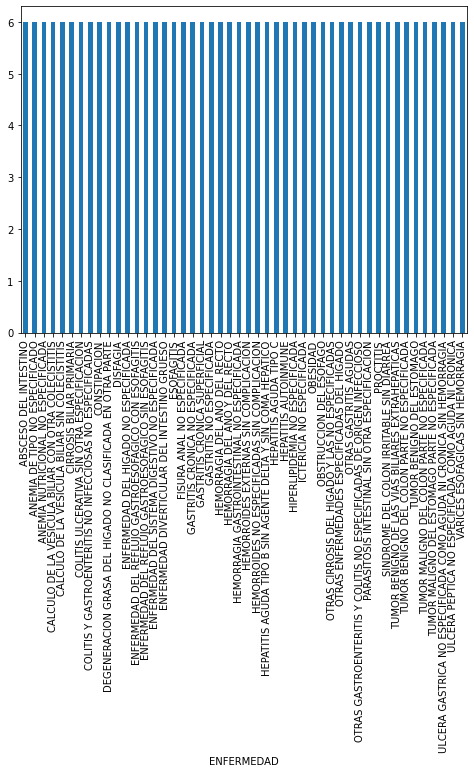

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('ENFERMEDAD').SINTOMA.count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.SINTOMA).toarray()
labels = df.ENFERMEDAD_ID
features.shape

(288, 726)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for ENFERMEDAD, ENFERMEDAD_ID in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == ENFERMEDAD_ID)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(ENFERMEDAD))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ABSCESO DEL INTESTINO':
  . Most correlated unigrams:
. malestar
. general
  . Most correlated bigrams:
. fiebre sensacion
. estomago fiebre
# 'ANEMIA DE TIPO NO ESPECIFICADO':
  . Most correlated unigrams:
. concentrarse
. irritabilidad
  . Most correlated bigrams:
. dolores cabeza
. fatiga irritabilidad
# 'ANEMIA NUTRICIONAL NO ESPECIFICADA':
  . Most correlated unigrams:
. por
. ulceras
  . Most correlated bigrams:
. las ulceras
. ulceras heces
# 'CALCULO DE LA VESICULA BILIAR CON OTRA COLECISTITIS':
  . Most correlated unigrams:
. centro
. extiende
  . Most correlated bigrams:
. derecha en
. extiende al
# 'CALCULO DE LA VESICULA BILIAR SIN COLECISTITIS':
  . Most correlated unigrams:
. derecho
. hombro
  . Most correlated bigrams:
. el hombro
. derecho dolor
# 'CIRROSIS BILIAR PRIMARIA':
  . Most correlated unigrams:
. musculos
. alteraciones
  . Most correlated bigrams:
. fatiga picores
. los musculos
# 'COLITIS ULCERATIVA SIN OTRA ESPECIFICACION':
  . Most correlated unigrams:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(df['SINTOMA'], df['ENFERMEDAD'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('mnb', MultinomialNB(0.2)),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('mnb',
                 MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True))],
         verbose=False)

In [7]:
input_sample = np.array(["Dolor abdominal Nauseas Vomitos Falta de apetito Aerofagia Heces oscuras Acidez estomacal"])

pd.DataFrame(text_clf.predict_proba(input_sample), columns=clf.classes_).to_records(index=False)

#pd.DataFrame(clf.predict_proba(count_vect.transform(input_sample)), columns=clf.classes_).to_records(index=False)

rec.array([(0.00301095, 0.00204379, 0.00739742, 0.0027638, 0.00545447, 0.00131298, 0.00322604, 0.00629891, 0.00164887, 0.00184761, 0.0114865, 0.0041748, 0.00266761, 0.00426934, 0.00639331, 0.00099995, 0.00345566, 0.00191074, 0.00603528, 0.00501549, 0.7914645, 0.0033757, 0.00230013, 0.00541356, 0.00177589, 0.00161727, 0.01082876, 0.00327945, 0.00175687, 0.00160729, 0.0094018, 0.00306383, 0.00289498, 0.00196529, 0.00561747, 0.00313275, 0.00602278, 0.00890544, 0.00153097, 0.00129669, 0.00460897, 0.00519419, 0.00446064, 0.00484232, 0.01305195, 0.00696521, 0.00696521, 0.00524659)],
          dtype=[('ABSCESO DEL INTESTINO', '<f8'), ('ANEMIA DE TIPO NO ESPECIFICADO', '<f8'), ('ANEMIA NUTRICIONAL NO ESPECIFICADA', '<f8'), ('CALCULO DE LA VESICULA BILIAR CON OTRA COLECISTITIS', '<f8'), ('CALCULO DE LA VESICULA BILIAR SIN COLECISTITIS', '<f8'), ('CIRROSIS BILIAR PRIMARIA', '<f8'), ('COLITIS ULCERATIVA SIN OTRA ESPECIFICACION', '<f8'), ('COLITIS Y GASTROENTERITIS NO INFECCIOSAS NO ESPECIFICADAS'

In [8]:
#print(clf.predict(count_vect.transform(["Dolor abdominal Nauseas Vomitos Falta de apetito Aerofagia Heces oscuras Acidez estomacal"])))
#print(clf.predict(count_vect.transform(["Alteraciones de los musculos y de las articulaciones Color amarillento en la piel y en los ojos (ictericia) Fatiga Picores (prurito) generalizados"])))
#print(clf.predict(count_vect.transform(["Acidez estomacal Indigestion y malestar estomacal Nauseas Perdida de apetito Sensacion de hinchazon despues de comer"])))
#print(clf.predict(count_vect.transform(["Acidez estomacal Dolor de estomago con ardor Eructos Intolerancia a los alimentos grasos Nauseas Sensacion de plenitud"])))
print(text_clf.predict(["Dolor abdominal Nauseas Vomitos Falta de apetito Aerofagia Heces oscuras Acidez estomacal"]))
#print(clf.predict(count_vect.transform(["Depresion Dificultad para dormir Dolor de espalda Fatiga Infecciones en los pliegues cutaneos Intolerancia al calor Sensacion de falta de aire (disnea) Sudoracion excesiva"])))
#print(clf.predict(count_vect.transform(["Acidez estomacal Comida tragada que se atasca en el esofago Dificultad para tragar Dolor al tragar (odinofagia) Dolor de pecho (angina) Regreso de los alimentos a la boca (regurgitacion)"])))

['GASTRITIS NO ESPECIFICADA']


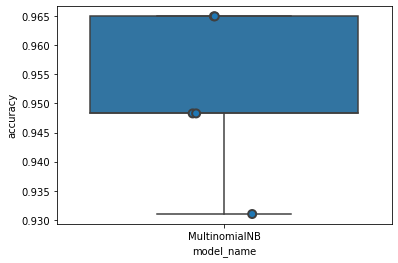

In [9]:
from sklearn.model_selection import cross_val_score
models = [
    MultinomialNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MultinomialNB    0.951482
Name: accuracy, dtype: float64

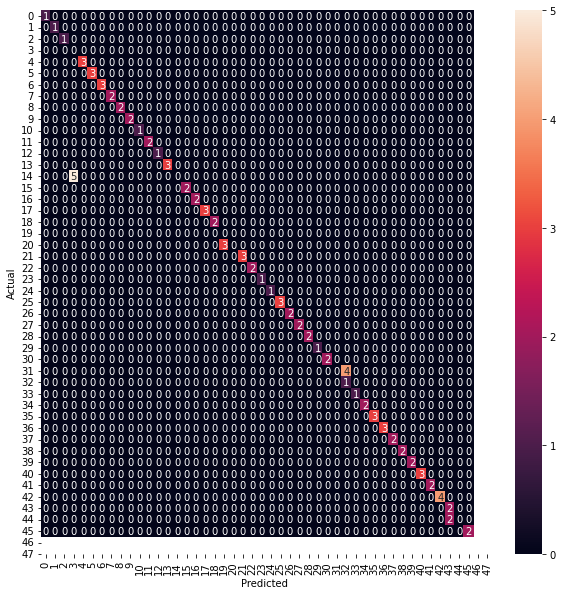

In [11]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.ENFERMEDAD_ID.values, yticklabels=category_id_df.ENFERMEDAD_ID.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# STOP

In [64]:
from sklearn.metrics import classification_report

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header) 
    return df

report_to_df(classification_report(y_test, y_pred))



,Class Name,precision,recall,f1-score,support
0,0,1.00,1.00,1.00,1
1,1,1.00,1.00,1.00,1
2,2,1.00,1.00,1.00,1
3,4,0.00,0.00,0.00,0
4,5,1.00,1.00,1.00,3
5,6,1.00,1.00,1.00,3
6,7,1.00,1.00,1.00,3
7,8,1.00,1.00,1.00,2
8,9,1.00,1.00,1.00,2
9,10,1.00,1.00,1.00,2


ValueError: multiclass format is not supported

In [12]:
import joblib

joblib.dump(text_clf, 'smepml_multinomialmb_model.pkl')

['smepml_multinomialmb_model.pkl']

In [13]:
import sklearn

from azureml.core import Workspace
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

ws = Workspace.from_config()

model = Model.register(workspace=ws,
                       model_name='multinomialmb_model',                # Name of the registered model in your workspace.
                       model_path='./smepml_multinomialmb_model.pkl',  # Local file to upload and register as a model.
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version=sklearn.__version__,  # Version of scikit-learn used to create the model.
                       resource_configuration=ResourceConfiguration(cpu=2, memory_in_gb=4),
                       description='Multinomial Naive Bayes to predict gastroenterology diseases.',
                       tags={'area': 'gastroenterology', 'type': 'MultinomialNB'})

print('Name:', model.name)
print('Version:', model.version)

Registering model multinomialmb_model
Name: multinomialmb_model
Version: 17


In [14]:
%%writefile score.py

import json
import pickle
import numpy as np
import pandas as pd
import os
import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType


def init():
    global model
    # Replace filename if needed.
    path = os.getenv('AZUREML_MODEL_DIR') 
    model_path = os.path.join(path, 'smepml_multinomialmb_model.pkl')
    # Deserialize the model file back into a sklearn model.
    model = joblib.load(model_path)

input_sample = np.array(["Aturdimiento Deposiciones oscuras o con sangre Perdida del conocimiento en casos graves Vomitos de sangre"])
# This is an integer type sample. Use the data type that reflects the expected result.
output_sample = np.array([0])

@input_schema('data', NumpyParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        df = pd.DataFrame(model.predict_proba(data), columns=model.classes_)

        d = df.apply(lambda c: str(c[0]).strip('[]')).to_dict()

        ds = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} 

        dt = {k: ds[k] for k in list(ds)[:5]}

        result = str(dt)
    # You can return any data type, as long as it can be serialized by JSON.
        return result
    except Exception as e:
        error = str(e)
        return error

Overwriting score.py


In [15]:
from azureml.core.model import InferenceConfig
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

environment = Environment('smepml-environment')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'pandas',
    'scikit-learn=={}'.format(sklearn.__version__)
])

inference_config = InferenceConfig(entry_script='./score.py',environment=environment)

In [16]:
service_name = 'multinomialnb-model-svc'

service = Model.deploy(ws, service_name, [model], inference_config, overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-11-08 18:35:48+00:00 Creating Container Registry if not exists.
2021-11-08 18:35:48+00:00 Registering the environment.
2021-11-08 18:35:50+00:00 Use the existing image.
2021-11-08 18:35:50+00:00 Generating deployment configuration.
2021-11-08 18:35:51+00:00 Submitting deployment to compute..
2021-11-08 18:35:54+00:00 Checking the status of deployment multinomialnb-model-svc..
2021-11-08 18:36:14+00:00 Checking the status of inference endpoint multinomialnb-model-svc.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [17]:
import json

input_payload = json.dumps({
    'data': ["Dolor abdominal Nauseas Vomitos Falta de apetito Aerofagia Heces oscuras Acidez estomacal"]
})

output = service.run(input_payload)

print(output)

{'GASTRITIS NO ESPECIFICADA': '0.7914644974661742', 'TUMOR MALIGNO DEL ESTOMAGO PARTE NO ESPECIFICADA': '0.013051948197017832', 'DISFAGIA': '0.01148650268832493', 'HEPATITIS AGUDA TIPO B SIN AGENTE DELTA Y SIN COMA HEPATICO': '0.010828759177840833', 'ICTERICIA NO ESPECIFICADA': '0.009401804788744984'}


In [18]:
from_jb= joblib.load("smepml_multinomialmb_model.pkl")

input_sample = np.array(["Aturdimiento Deposiciones oscuras o con sangre Perdida del conocimiento en casos graves Vomitos de sangre"])

df = pd.DataFrame(from_jb.predict_proba(input_sample), columns=from_jb.classes_)

d = df.apply(lambda c: str(c[0]).strip('[]')).to_dict()

ds = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} 

dt = {k: ds[k] for k in list(ds)[:5]}

str(dt)

"{'VARICES ESOFAGICAS SIN HEMORRAGIA': '0.9175932870184269', 'ANEMIA NUTRICIONAL NO ESPECIFICADA': '0.014836149099386497', 'HEMORRAGIA GASTROINTESTINAL NO ESPECIFICADA': '0.00407733533922015', 'PARASITOSIS INTESTINAL SIN OTRA ESPECIFICACION': '0.003843500927661138', 'TUMOR BENIGNO DEL COLON PARTE NO ESPECIFICADA': '0.0037240860568369142'}"